In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install keras_cv -q
!pip install tensorflow-datasets==4.9.6 -q

In [ ]:
from tensorflow.keras import backend as K
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import os
import pickle
from pathlib import Path
import keras
import keras_cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from segmentation_utils import rescale_images_and_correct_masks, unpackage_inputs, DisplayCallback, plot_history, show_predicted_masks
from unet_utils import unet
from deep_lab_utils import DeeplabV3Plus

# Lab 3: Segmentation

Segmentation is the process of partitioning an image into multiple segments. The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze. Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

### Task nomenclature

Segmentation could assume different meaning according to the information extracted from the image. The most common tasks are:

* Object Detection definition
![ObjectDetection](https://ai.google.dev/static/edge/mediapipe/images/solutions/examples/object_detector.png)
* <font color='orange'>**Semantic Segmentation**</font> definition<br>
![Image Segmentation](https://cdn.prod.website-files.com/614c82ed388d53640613982e/63f498f8d4fe7da3b3a60cc2_semantic%20segmentation%20vs%20instance%20segmentation.jpg)
* Instance Segmentation definition<br>
![Instance Segmentation](https://drive.google.com/uc?id=1xO189Tlv8GbE86sncajEn6LmkE3NTu6l)
* Panoptic Segmentation definition<br>
![Panoptic Segmentation](https://miro.medium.com/v2/resize:fit:544/1*pHdS7CNYL-Hc__RqevY5mA.png)


### Metrics for semantic segmentation

In order to evaluate the performance of a segmentation model, we need to define some metrics. Some of them metrics are:

* <font color='orange'>**Intersection over Union (IoU) definition**</font>
$$ IoU_{pixel} = \frac{\sum_{i=1}^{N}(P_i \cap G_i)}{\sum_{i=1}^{N}(P_i \cup G_i)} $$
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$Where:

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  *Pi* is the predicted segmentation mask at pixel i,
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  *Gi* is the ground truth mask at pixel i,
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  *N* is the total number of pixels in the image.
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ ![IoU](https://miro.medium.com/max/300/0*kraYHnYpoJOhaMzq.png)
* Mean Intersection over Union (mIoU) definition
* <font color='orange'>**Pixel Accuracy definition**</font>
$$
\text{Accuracy} = \frac{\text{Number of right predictions}}{\text{Total number of predictions}}
$$
* Mean Pixel Accuracy definition
* Mean Class Accuracy definition
* Frequency Weighted Intersection over Union definition
* Mean Frequency Weighted Intersection over Union definition
* <font color='orange'>**Dice Coefficient definition**</font>
$$ \text{Dice} = 2\times \frac{|X \cap Y|}{|X|+|Y|} $$
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ ![Dice Coefficient](https://miro.medium.com/v2/resize:fit:429/1*yUd5ckecHjWZf6hGrdlwzA.png)

In [ ]:
def iou_coeff(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(K.greater(y_pred, 0.5), dtype=tf.float32)
    smooth = 1  # Smoothing factor to avoid division by zero

    # Compute intersection and union
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection

    # Compute IoU
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coeff(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    smooth = 1
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2 * intersection + smooth)/(union + smooth), axis=0)
    dice = K.clip(dice, 0, 1)
    return dice

def evaluate_model(model, validation_dataset, fun):
    y_pred = model.predict(validation_dataset)
    y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
    y_pred = y_pred.astype('float32')
    y_true = y_true.astype('float32')
    evaluation_result = fun(y_true, y_pred)
    return evaluation_result

### Mask

Img shape: (416, 735, 3)


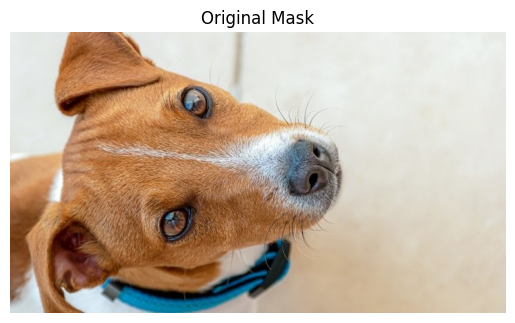

In [ ]:
url="https://drive.google.com/uc?id=1vWgkE4_TUuBJhlsZv7JdURRCM_WoYNRl"
img = imageio.imread(url)#download a picture

plt.imshow(img)
plt.title('Original Mask')
plt.axis('off')
print("Img shape:",img.shape)

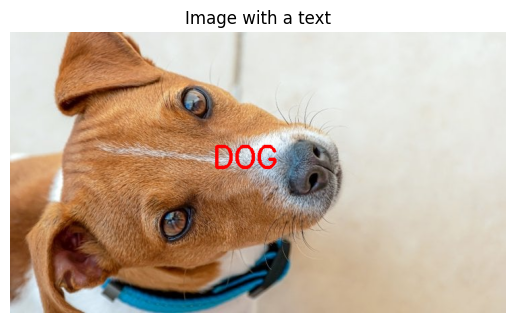

Text Img shape: (416, 735, 3)


In [ ]:
text = 'DOG'
my_color =  [255,0,0] #Red of rgb
text_image = cv2.putText(img.copy(), text,(300, 200), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=my_color, thickness=3)

# Display the image with text
plt.imshow(text_image)  # Matplotlib converts from greyscale to a colormap
plt.axis('off')  # Hide axes
plt.title('Image with a text')
plt.show()
print("Text Img shape:",text_image.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mask shape: (416, 735)


(-0.5, 734.5, 415.5, -0.5)

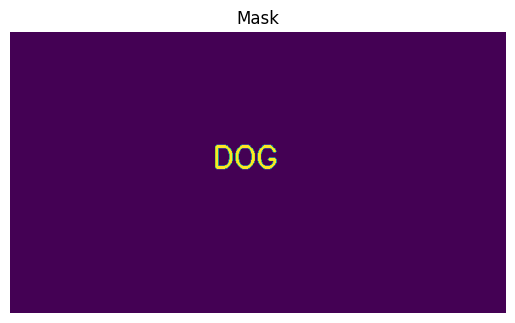

In [ ]:
color_red = [255,0,0]
mask = (text_image == color_red).all(axis=2).astype(np.uint8)
print( mask )
print("mask shape:", mask.shape)
#the mask is printable
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

## Semantic Segmentation

One of the tasks linked to segmentation is the semantic segmentation, which is solved using deep learning models processing images to generate images of the same size with the same number of channels as the input image. Each pixel in the output image is assigned a class label, which represents the class of the object to which the pixel belongs.

In [ ]:
# Image Config
HEIGHT = 64
WIDTH = 64
NUM_CLASSES = 3
AUTOTUNE = tf.data.AUTOTUNE #optimize hw performance automatically
BATCH_SIZE = 32

dir="./model_weights"
if not Path(dir).exists():
  os.mkdir(dir)
  print("Folder was created")

Folder was created


In this tutorial we are going to introduce [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). This dataset is a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed.

In [ ]:
#Download the datasets
tfds.disable_progress_bar()
orig_train_ds, orig_val_ds, orig_test_ds  = tfds.load(
    name="oxford_iiit_pet",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
)

# Calcola il numero di elementi in ciascun dataset
num_train_elements = tf.data.experimental.cardinality(orig_train_ds).numpy()
num_val_elements = tf.data.experimental.cardinality(orig_val_ds).numpy()
num_test_elements = tf.data.experimental.cardinality(orig_val_ds).numpy()

print("Training set length:", num_train_elements)
print("Test set length:", num_val_elements)
print("Test set length:", num_test_elements)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
Training set length: 2944
Test set length: 368
Test set length: 368


In [ ]:
train_ds = orig_train_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)
val_ds = orig_val_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)
test_ds = orig_test_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)

resize_fn = keras_cv.layers.Resizing( HEIGHT, WIDTH )

resized_train_ds = (
    train_ds.map(resize_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

resized_val_ds = (
    val_ds.map(resize_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

resized_test_ds = (
    test_ds.map(resize_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Image Shape: (4, None, None, 3)
Segmentation Mask Shape: (4, None, None, 1)


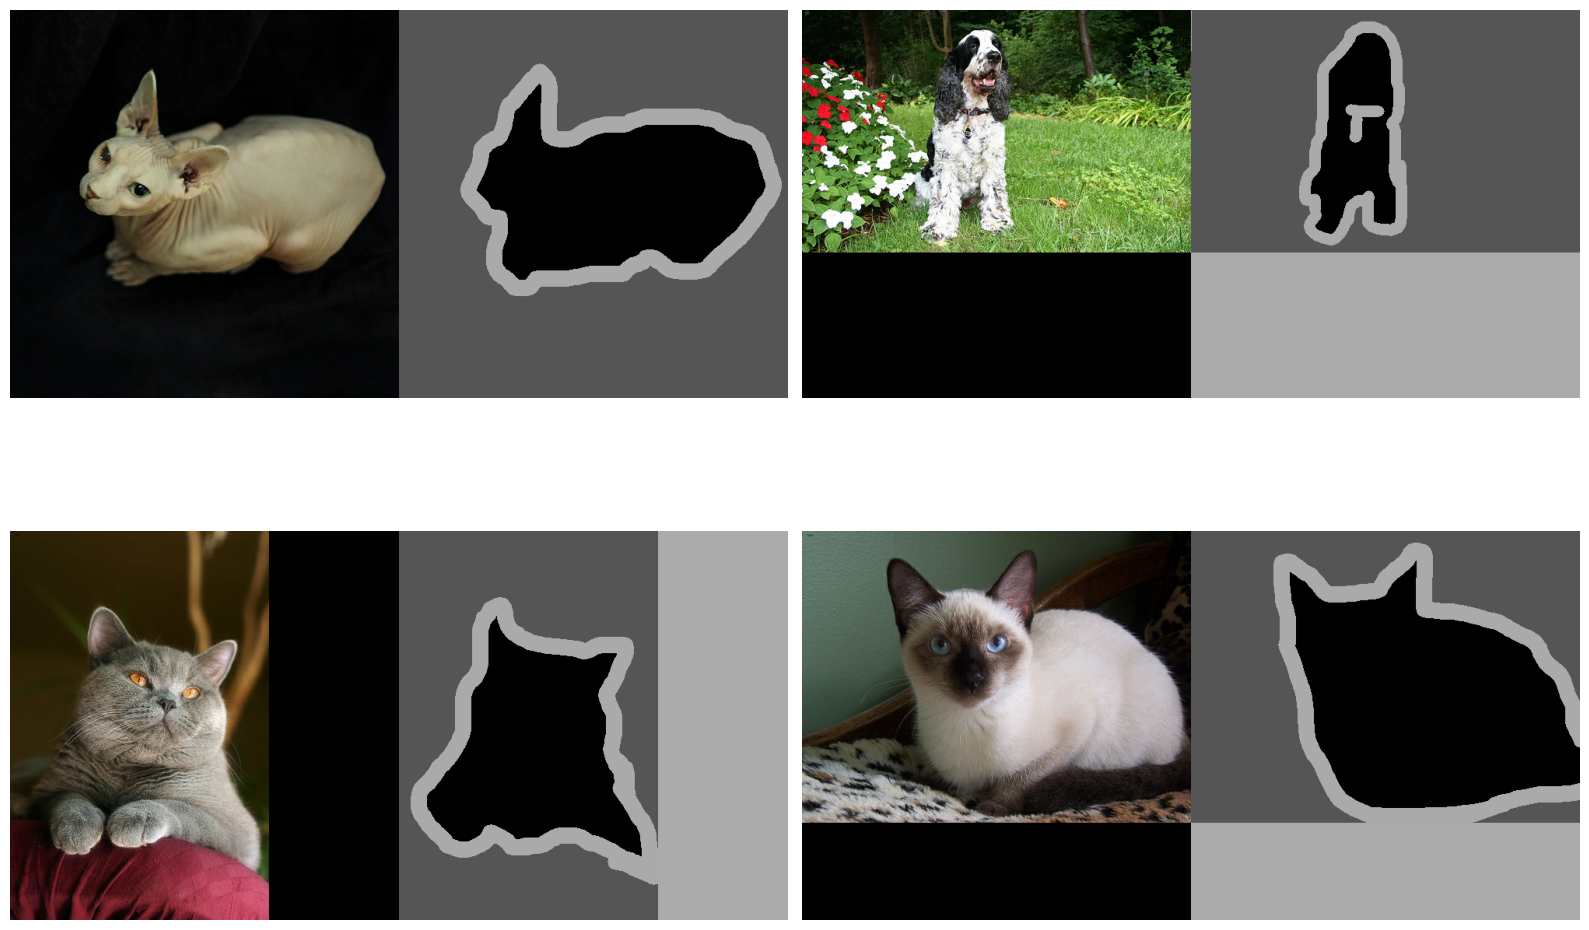

In [ ]:
plot_train_ds = train_ds.map(unpackage_inputs).ragged_batch(4)
#resized_train_ds
images, segmentation_masks = next(iter(plot_train_ds.take(1)))

print( f"Image Shape: {images.shape}"  )
print( f"Segmentation Mask Shape: {segmentation_masks.shape}"  )

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=8,
    rows=2,
    cols=2,
)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    restore_best_weights=True,
    start_from_epoch=0,
    patience=3
)

unet_save_path = f"./model_weights/unet_weights_img {WIDTH} x {HEIGHT}.weights.h5"

display_callback = DisplayCallback(resized_val_ds, BATCH_SIZE, epoch_interval=3,save_path=unet_save_path)

callbacks = [display_callback, early_stopping]

## Semantic Segmentation architectures

* UNET
* DeepLab

### UNET

Maybe the most known network architecture used for segmentation is the UNet.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

its architecture is based on the formula that you studied to compute the receptive field of a convolutional neural network:

$$
D' = S(D-1) + K
$$

where $D'$ is the receptive field of the previous layer, $D$ is the receptive field on the following layer, $S$ is the stride and $K$ is the kernel size. \\

A consequence of this formula is that the receptive field increases exponentially while moving down, linearly while moving right. \\

The drawback of downsampling, which is the information loss, is solved by UNet by adding skip connections, that also act as training stabilizer. \\

Note that, at every downsampling (which in this case is implemented as a MaxPooling2D layer), the number of filters double, to reduce the impact of the dimensionality loss (the total number of pixel after downsampling is divided by 4).

In [ ]:
unet_model = unet(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)
unet_model.summary()

if tf.test.gpu_device_name():
    print('TensorFlow is using GPU/TPU')
else:
    print('TensorFlow is using CPU')

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 16, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 8, 256)      │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 768)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 256)    │      1,769,728 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 32, 32, 256)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)       

 Total params: 7,784,579 (29.70 MB)

 Trainable params: 7,784,579 (29.70 MB)

 Non-trainable params: 0 (0.00 B)

TensorFlow is using CPU


No weights loaded.
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


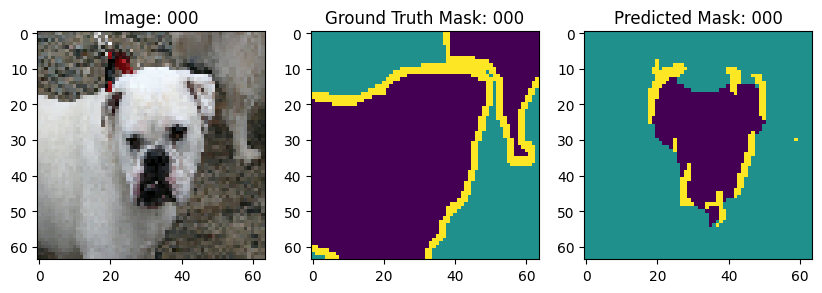

92/92 ━━━━━━━━━━━━━━━━━━━━ 1119s 12s/step - accuracy: 0.6782 - dice_coeff: 0.8904 - iou_coeff: 0.7048 - loss: 0.7885 - val_accuracy: 0.7611 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7207 - val_loss: 0.5916
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1116s 12s/step - accuracy: 0.7745 - dice_coeff: 0.8904 - iou_coeff: 0.7113 - loss: 0.5699 - val_accuracy: 0.7978 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7297 - val_loss: 0.5146
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1102s 12s/step - accuracy: 0.8000 - dice_coeff: 0.8904 - iou_coeff: 0.7335 - loss: 0.5103 - val_accuracy: 0.8007 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7489 - val_loss: 0.4983
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


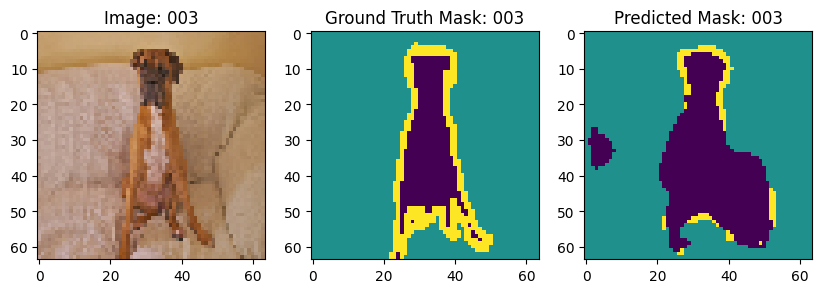

92/92 ━━━━━━━━━━━━━━━━━━━━ 1104s 12s/step - accuracy: 0.8176 - dice_coeff: 0.8904 - iou_coeff: 0.7430 - loss: 0.4702 - val_accuracy: 0.8189 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7571 - val_loss: 0.4617
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1098s 12s/step - accuracy: 0.8345 - dice_coeff: 0.8904 - iou_coeff: 0.7539 - loss: 0.4275 - val_accuracy: 0.8309 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7630 - val_loss: 0.4422
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1104s 12s/step - accuracy: 0.8424 - dice_coeff: 0.8904 - iou_coeff: 0.7572 - loss: 0.4064 - val_accuracy: 0.8370 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7641 - val_loss: 0.4220
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


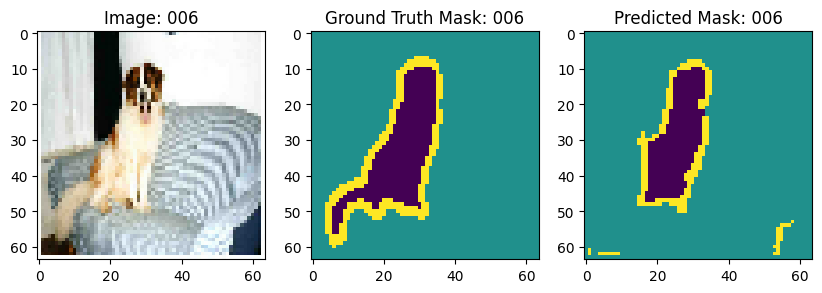

92/92 ━━━━━━━━━━━━━━━━━━━━ 1088s 12s/step - accuracy: 0.8544 - dice_coeff: 0.8904 - iou_coeff: 0.7628 - loss: 0.3774 - val_accuracy: 0.8407 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7686 - val_loss: 0.4121
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1086s 12s/step - accuracy: 0.8585 - dice_coeff: 0.8904 - iou_coeff: 0.7657 - loss: 0.3653 - val_accuracy: 0.8446 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7745 - val_loss: 0.4100
Epoch 9/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1103s 12s/step - accuracy: 0.8666 - dice_coeff: 0.8904 - iou_coeff: 0.7688 - loss: 0.3463 - val_accuracy: 0.8511 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7728 - val_loss: 0.3986
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


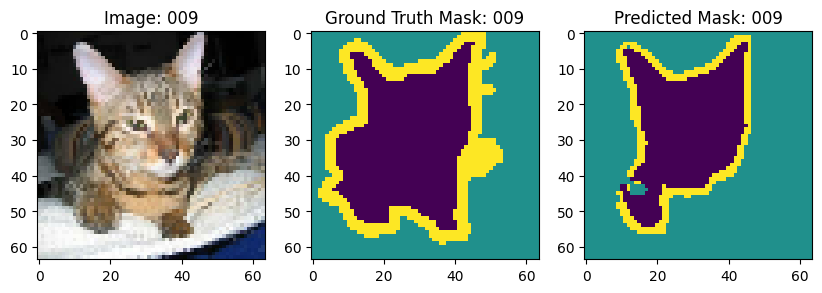

92/92 ━━━━━━━━━━━━━━━━━━━━ 1110s 12s/step - accuracy: 0.8710 - dice_coeff: 0.8904 - iou_coeff: 0.7716 - loss: 0.3364 - val_accuracy: 0.8422 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7803 - val_loss: 0.4265
Epoch 11/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1085s 12s/step - accuracy: 0.8701 - dice_coeff: 0.8904 - iou_coeff: 0.7711 - loss: 0.3390 - val_accuracy: 0.8545 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7698 - val_loss: 0.3910
Epoch 12/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1087s 12s/step - accuracy: 0.8777 - dice_coeff: 0.8904 - iou_coeff: 0.7752 - loss: 0.3157 - val_accuracy: 0.8487 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7741 - val_loss: 0.4014
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


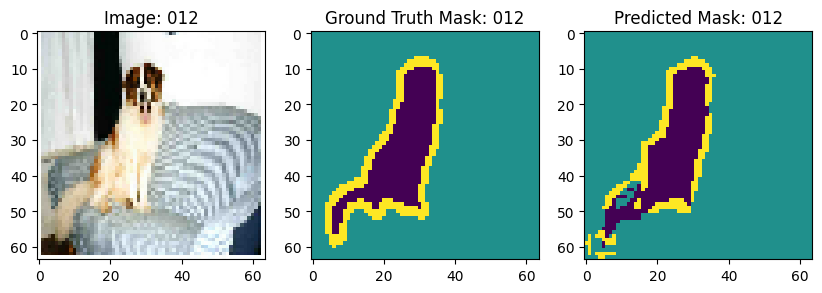

92/92 ━━━━━━━━━━━━━━━━━━━━ 1106s 12s/step - accuracy: 0.8817 - dice_coeff: 0.8904 - iou_coeff: 0.7768 - loss: 0.3072 - val_accuracy: 0.8487 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7812 - val_loss: 0.4258
Epoch 14/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1082s 12s/step - accuracy: 0.8885 - dice_coeff: 0.8904 - iou_coeff: 0.7791 - loss: 0.2867 - val_accuracy: 0.8439 - val_dice_coeff: 0.8912 - val_iou_coeff: 0.7825 - val_loss: 0.4092


In [ ]:
# Training Config
LEARNING_RATE = 1e-3

unet_model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", iou_coeff, dice_coeff],
)

train_network = False

try:
    unet_model.load_weights(unet_save_path)
    EPOCHS = 1
    print("The model was loaded.")
except Exception as e:
    EPOCHS = 15
    print(f"No weights loaded.")


if train_network:
    unet_history = unet_model.fit(resized_train_ds,
                              epochs=EPOCHS,
                              validation_data=resized_val_ds,
                              callbacks=callbacks)

In [ ]:
unet_model.save_weights(unet_save_path)

In [ ]:
pickle.dump(unet_history.history, open("unet_history.pkl", "wb"))

In [ ]:
# change remove history from unet_history_old.history['loss']

import os
show_new_history = False

if os.path.exists('unet_history.pkl') and show_new_history:
    unet_history_old = pickle.load(open('unet_history.pkl', 'rb'))
    unet_loss_history = unet_history_old['loss'] + unet_history.history['loss']
    unet_val_loss_history = unet_history_old['val_loss'] + unet_history.history['val_loss']
    unet_acc_history = unet_history_old['accuracy'] + unet_history.history['accuracy']
    unet_val_acc_history = unet_history_old['val_accuracy'] + unet_history.history['val_accuracy']
    unet_iou_history = unet_history_old['iou_coeff'] + unet_history.history['iou_coeff']
    unet_val_iou_history = unet_history_old['val_iou_coeff'] + unet_history.history['val_iou_coeff']
    unet_dice_history = unet_history_old['dice_coeff'] + unet_history.history['dice_coeff']
    unet_val_dice_history = unet_history_old['val_dice_coeff'] + unet_history.history['val_dice_coeff']

elif os.path.exists('unet_history.pkl') and not show_new_history :
    unet_history_old = pickle.load(open('unet_history.pkl', 'rb'))
    unet_loss_history = unet_history_old['loss']
    unet_val_loss_history = unet_history_old['val_loss']
    unet_acc_history = unet_history_old['accuracy']
    unet_val_acc_history = unet_history_old['val_accuracy']
    unet_iou_history = unet_history_old['iou_coeff']
    unet_val_iou_history = unet_history_old['val_iou_coeff']
    unet_dice_history = unet_history_old['dice_coeff']
    unet_val_dice_history = unet_history_old['val_dice_coeff']

else:
    unet_loss_history = unet_history.history['loss']
    unet_val_loss_history = unet_history.history['val_loss']
    unet_acc_history = unet_history.history['accuracy']
    unet_val_acc_history = unet_history.history['val_accuracy']
    unet_iou_history = unet_history.history['iou_coeff']
    unet_val_iou_history = unet_history.history['val_iou_coeff']
    unet_dice_history = unet_history.history['dice_coeff']
    unet_val_dice_history = unet_history.history['val_dice_coeff']

In [ ]:
plot_history(unet_loss_history, unet_val_loss_history, 'Loss')

In [ ]:
plot_history(unet_acc_history, unet_val_acc_history, 'Accuracy')

In [ ]:
plot_history(unet_iou_history, unet_val_iou_history, 'IoU')

In [ ]:
plot_history(unet_dice_history, unet_val_dice_history, 'Dice')

### Deeplab

The DeepLabV3+ model is a deep learning model for semantic image segmentation. It is an improved version of the DeepLabV3 model that uses a decoder to better segment objects. The DeepLabV3+ model uses the Xception backbone to extract features from the input image and then uses atrous spatial pyramid pooling (ASPP) to capture context information. The model then uses a decoder to refine the segmentation mask.

![Deeplab](https://ars.els-cdn.com/content/image/1-s2.0-S0168169923008955-gr3.jpg)

### ASPP (Atrous Spatial Pyramid Pooling) definition
The Atrous Spatial Pyramid Pooling (ASPP) module is used to capture context information at multiple scales. The ASPP module uses atrous convolution with different rates to capture context information at different scales. The ASPP module consists of multiple parallel atrous convolution layers with different rates, followed by a global average pooling layer and a 1x1 convolution layer. The output of the ASPP module is a feature map that contains context information at multiple scales.

In [ ]:
deep_lab_model = DeeplabV3Plus(image_size=64, num_classes=NUM_CLASSES)
deep_lab_model.summary()

In [ ]:
deep_lab_save_path = f"./model_weights/deep_lab_weights_img {WIDTH} x {HEIGHT}.weights.h5"

display_callback = DisplayCallback(resized_val_ds, BATCH_SIZE, epoch_interval=3,save_path=deep_lab_save_path)

callbacks = [display_callback, early_stopping]

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
deep_lab_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy", iou_coeff, dice_coeff]
)

# train_model = False

try:
    deep_lab_model.load_weights(deep_lab_save_path)
    EPOCHS = 1
    print("The model was loaded.")
except Exception as e:
    EPOCHS = 15
    print(f"No weights loaded.")


# if train_model:
deep_lab_history = deep_lab_model.fit(resized_train_ds,
                    validation_data=resized_val_ds,
                    callbacks=callbacks,
                    epochs=EPOCHS)

In [ ]:
deep_lab_model.save_weights(deep_lab_save_path)

In [ ]:
pickle.dump(unet_history, open("deep_lab_history.pkl", "wb"))

In [ ]:
show_new_history = False

if os.path.exists('deep_lab_history.pkl') and show_new_history:
    deep_lab_history_old = pickle.load(open('deep_lab_history.pkl', 'rb'))
    deep_lab_loss_history = deep_lab_history_old['loss'] + deep_lab_history.history['loss']
    deep_lab_val_loss_history = deep_lab_history_old['val_loss'] + deep_lab_history.history['val_loss']
    deep_lab_acc_history = deep_lab_history_old['accuracy'] + deep_lab_history.history['accuracy']
    deep_lab_val_acc_history = deep_lab_history_old['val_accuracy'] + deep_lab_history.history['val_accuracy']
    deep_lab_iou_history = deep_lab_history_old['iou_coeff'] + deep_lab_history.history['iou_coeff']
    deep_lab_val_iou_history = deep_lab_history_old['val_iou_coeff'] + deep_lab_history.history['val_iou_coeff']
    deep_lab_dice_history = deep_lab_history_old['dice_coeff'] + deep_lab_history.history['dice_coeff']
    deep_lab_val_dice_history = deep_lab_history_old['val_dice_coeff'] + deep_lab_history.history['val_dice_coeff']

elif os.path.exists('deep_lab_history.pkl') and not show_new_history :
    deep_lab_history_old = pickle.load(open('deep_lab_history.pkl', 'rb'))
    deep_lab_loss_history = deep_lab_history_old['loss']
    deep_lab_val_loss_history = deep_lab_history_old['val_loss']
    deep_lab_acc_history = deep_lab_history_old['accuracy']
    deep_lab_val_acc_history = deep_lab_history_old['val_accuracy']
    deep_lab_iou_history = deep_lab_history_old['iou_coeff']
    deep_lab_val_iou_history = deep_lab_history_old['val_iou_coeff']
    deep_lab_dice_history = deep_lab_history_old['dice_coeff']
    deep_lab_val_dice_history = deep_lab_history_old['val_dice_coeff']

else:
    deep_lab_loss_history = deep_lab_history.history['loss']
    deep_lab_val_loss_history = deep_lab_history.history['val_loss']
    deep_lab_acc_history = deep_lab_history.history['accuracy']
    deep_lab_val_acc_history = deep_lab_history.history['val_accuracy']
    deep_lab_iou_history = deep_lab_history.history['iou_coeff']
    deep_lab_val_iou_history = deep_lab_history.history['val_iou_coeff']
    deep_lab_dice_history = deep_lab_history.history['dice_coeff']
    deep_lab_val_dice_history = deep_lab_history.history['val_dice_coeff']

In [ ]:
plot_history(deep_lab_loss_history, deep_lab_val_loss_history, 'Loss')

In [ ]:
plot_history(deep_lab_acc_history, deep_lab_val_acc_history, 'Accuracy')

In [ ]:
plot_history(deep_lab_iou_history, deep_lab_val_iou_history, 'IoU')

In [ ]:
plot_history(deep_lab_dice_history, deep_lab_val_dice_history, 'Dice')

## Generalization Results

UNet results:

In [ ]:
unet_test_dice = evaluate_model(unet_model, resized_test_ds, dice_coeff)
unet_test_iou = evaluate_model(unet_model, resized_test_ds, iou_coeff)

print(f"UNet Test Dice: {unet_test_dice}")
print(f"UNet Test IoU: {unet_test_iou}")

Visualize UNet prediction:

In [ ]:
show_predicted_masks(test_ds, num_test_elements, unet_model)

DeepLabV3+ results:

In [ ]:
deep_lab_test_dice = evaluate_model(deep_lab_model, resized_test_ds, dice_coeff)
deep_lab_test_iou = evaluate_model(deep_lab_model, resized_test_ds, iou_coeff)

print(f"DeepLabV3+ Test Dice: {deep_lab_test_dice}")
print(f"DeepLabV3+ Test IoU: {deep_lab_test_iou}")

Visulaize DeepLabV3+ prediction:

In [ ]:
show_predicted_masks(test_ds, num_test_elements, deep_lab_model)

# Exercises

1.  Implement the DeepLabV3+ model using the MobileNetV2 and Xception backbone.
2.  Check the performance of the model using dice coefficient and intersection over union as main metric.
3.  Implement the function for computing the Pixel Accuracy and check the performance of the models considered so far.
4. Implement the fuction for computing Mean Class Accuracy and compare the performance of the models defined so far.
5.  Apply hyper-parameter tuning on the models so fare defined
6.  Apply data augmentation for enhancing the generalization power of your model where required.
7.  (Optional) Try to apply all we learnt to one of the following datasets:

  *   Pascal2:11540 images,6,929 segmentation masks and 20 categories.
     http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html:

  *   ADEK20:images 25K+2K and 150 categories.
     https://groups.csail.mit.edu/vision/datasets/ADE20K/
  *   Cityscapes Dataset: https://www.cityscapes-dataset.com/
  *   Mapillar Vistas: https://www.mapillary.com/dataset/vistas
